In [1]:
!pip install tonic --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00


In [3]:
import tonic
train = tonic.datasets.DVSGesture(save_to="/kaggle/working/", train=True)
test = tonic.datasets.DVSGesture(save_to="/kaggle/working/", train=False)

  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting /kaggle/working/DVSGesture/ibmGestureTrain.tar.gz to /kaggle/working/DVSGesture


  0%|          | 0/691455012 [00:00<?, ?it/s]

Extracting /kaggle/working/DVSGesture/ibmGestureTest.tar.gz to /kaggle/working/DVSGesture


In [2]:
dataset_path = "/kaggle/working/"

In [4]:
import numpy as np
import numpy.lib.recfunctions as rf

In [5]:
import tonic
import matplotlib.pyplot as plt
from IPython.display import HTML

In [6]:
class tile_images:
    def __init__(self, h, w, outer_h, outer_w):
      #h and w represent the dimensions of the image to be tiled
      self.h = h
      self.w = w
      #outer_* represents how many images should be tiled along each dim
      self.outer_h = outer_h
      self.outer_w = outer_w
      #We're gonna cheat and assume all inputs have 2 channels
      #Which we hard code tonic's ToFrame to have

    def __call__(self, frames):
      flattened_arr = np.zeros((3, self.h * self.outer_h, self.w * self.outer_w))
      for i in range(self.outer_h):
        for j in range(self.outer_h):
          idx = i*self.outer_h + j
          flattened_arr[:, 16*i:16*i+16, 16*j:16*j+16] += frames[idx]
      return flattened_arr

#This is the dims of a single token in the transformer
h, w = 16, 16
#This is used to match the token size of the expected input size
outer_h, outer_w = 224 // h, 224 // w
#Make sure we can use all of the generated frames
n_frames = outer_h * outer_w

fit_ViT_input = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000), # removes outlier events with inactive surrounding pixels for 10ms
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(16,16)), # downsampling image
    tonic.transforms.ToFrame(sensor_size=(16,16,3), n_time_bins=n_frames), # n_frames frames per trail
    tile_images(h, w, outer_h, outer_w)
    ])

base_transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000), # removes outlier events with inactive surrounding pixels for 10ms
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(16,16)), # downsampling image
    tonic.transforms.ToFrame(sensor_size=(h,w,2), n_time_bins=196), # n_frames frames per trail
    ])


events, label = train[0]

og_output = base_transforms(train[0][0])
transformer_output = fit_ViT_input(train[0][0])

(3, 224, 224)
(196, 2, 16, 16)


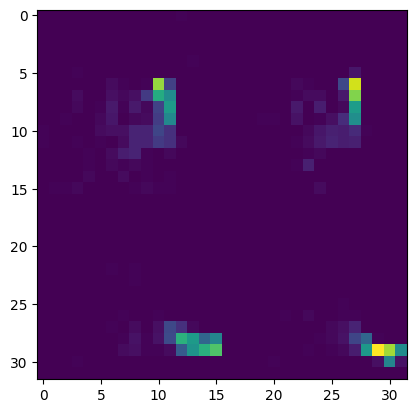

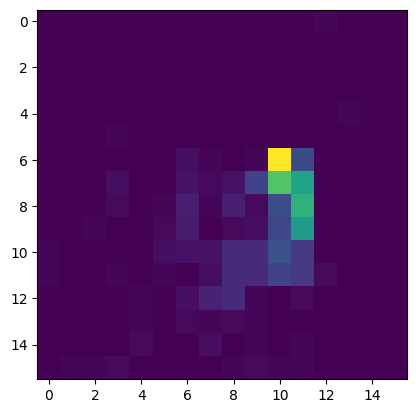

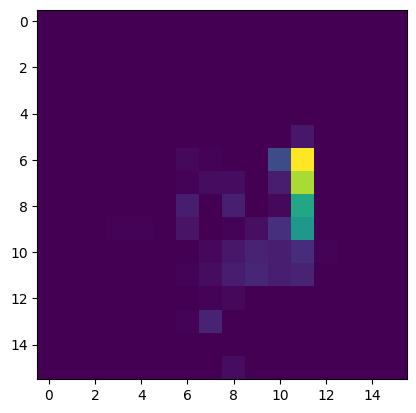

In [7]:
#This cell just demonstrates that we're tiling out outputs
#The first 2 tiles of the output match the first 2 images
def display_frame(frame_2c):
  new_image = np.zeros((3, frame_2c.shape[1], frame_2c.shape[2]))
  new_image[:2, ...] += frame_2c
  plt.imshow(new_image[0])
  plt.show()

print(transformer_output.shape)
print(og_output.shape)

plt.imshow(transformer_output[0, :32, :32])
plt.show()
display_frame(og_output[0])
display_frame(og_output[1])

In [8]:
#Now using this transform we can create out train/test dataset
ViT_train = tonic.datasets.DVSGesture(save_to=dataset_path, transform=fit_ViT_input, train=True)
ViT_test = tonic.datasets.DVSGesture(save_to=dataset_path, transform=fit_ViT_input, train=False)

In [9]:
#Now that the data is mostly set up, lets import what we need for training
!pip install transformers --quiet
import torch
import torch.nn as nn
from transformers import ViTModel
from transformers import ViTModel, ViTConfig
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

In [10]:
class ViT(nn.Module):

  def __init__(self, config=ViTConfig(), num_labels=20,
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels)
        )

  def forward(self, x):

    x = self.vit(x)['last_hidden_state']
    # Use the embedding of [CLS] token
    output = self.classifier(x[:, 0, :])

    return output

In [11]:
BATCH_SIZE = 32
train_dataloader = DataLoader(ViT_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(ViT_test, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
print(len(ViT_train))

1077


In [15]:
from keras import backend as K
K.clear_session()
from tqdm import tqdm
import os
from skimage.transform import resize
from skimage.io import imread
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load nodel, loss function, and optimizer
    model = ViT(num_labels=11).to(device) #model initialisation
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Fine tuning loop
    for i in range(epochs):
        total_runs = 0
        total_acc_train = 0
        total_loss_train = 0.0

        for train_image, train_label in tqdm(dataset):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_runs += len(train_label)
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(dataset): .3f} | Accuracy: {total_acc_train / total_runs: .3f}')

    return model

# Hyperparameters
EPOCHS = 20
LEARNING_RATE = 1e-4

# Train the model
trained_model = model_train(train_dataloader, EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  3%|▎         | 1/34 [02:03<1:08:00, 123.66s/it]